In [23]:
from PIL import Image
import pandas as pd 
import os
import numpy as np 
import random

In [24]:
# Path to all data
DATA_PATH = "../dataset_mri/lgg-mri-segmentation/kaggle_3m/"

Preprocessing 

In [25]:
def load_dataset(data_path):
    # Go through all files and create dictionary containing the data
    images_dict = {}
    for path, subdirs, files in os.walk(data_path):
        for name in files:
            if 'tif' in name:
                file_path = os.path.join(path, name)

                # Load image to store it as a numpy array in the dict
                img = Image.open(file_path)

                if 'mask' in name:
                    img_id = name[:-9]               

                    if img_id in images_dict:
                        images_dict[img_id]['mask_path'] = file_path
                    else:
                        images_dict[img_id] = {'mask_path': file_path}

                    images_dict[img_id]['mask_data'] = np.array(img)
                else:
                    img_id = name[:-4]

                    # Only keep the FLAIR part of the tif image
                    img_array = np.array(img)
                    img_flair_array = img_array[:, :, 1]

                    if img_id in images_dict:
                        images_dict[img_id]['image_path'] = file_path
                    else:
                        images_dict[img_id] = {'image_path': file_path}
                    
                    images_dict[img_id]['image_data'] = np.array(img_flair_array)

    # Create pandas dataframe from images_dict
    dataset = pd.DataFrame.from_dict(images_dict, orient='index').reset_index()
    dataset = dataset.rename(columns={'index': 'patient_id'})

    # Delete images_dict from memory
    images_dict.clear()

    # Add target values
    dataset['tumor'] = dataset['mask_data'].apply(lambda x: 1 if np.max(x) > 0 else 0)

    return dataset

In [26]:
load_dataset(DATA_PATH)

,patient_id,image_path,image_data,mask_path,mask_data,tumor
0,TCGA_CS_4941_19960909_1,../dataset_mri/lgg-mri-segmentation/kaggle_3m/...,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",../dataset_mri/lgg-mri-segmentation/kaggle_3m/...,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",0
1,TCGA_CS_4941_19960909_10,../dataset_mri/lgg-mri-segmentation/kaggle_3m/...,"[[2, 3, 3, 2, 2, 2, 1, 2, 2, 1, 1, 1, 2, 3, 4,...",../dataset_mri/lgg-mri-segmentation/kaggle_3m/...,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",0
2,TCGA_CS_4941_19960909_11,../dataset_mri/lgg-mri-segmentation/kaggle_3m/...,"[[1, 1, 2, 2, 3, 2, 4, 3, 3, 3, 2, 2, 2, 3, 5,...",../dataset_mri/lgg-mri-segmentation/kaggle_3m/...,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1
3,TCGA_CS_4941_19960909_12,../dataset_mri/lgg-mri-segmentation/kaggle_3m/...,"[[4, 2, 2, 4, 3, 2, 2, 2, 3, 4, 4, 3, 2, 2, 3,...",../dataset_mri/lgg-mri-segmentation/kaggle_3m/...,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1
4,TCGA_CS_4941_19960909_13,../dataset_mri/lgg-mri-segmentation/kaggle_3m/...,"[[3, 1, 2, 3, 2, 3, 4, 5, 6, 5, 3, 2, 2, 2, 4,...",../dataset_mri/lgg-mri-segmentation/kaggle_3m/...,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1
...,...,...,...,...,...,...
3924,TCGA_HT_A61B_19991127_85,../dataset_mri/lgg-mri-segmentation/kaggle_3m/...,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",../dataset_mri/lgg-mri-segmentation/kaggle_3m/...,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",0
3925,TCGA_HT_A61B_19991127_86,../dataset_mri/lgg-mri-segmentation/kaggle_3m/...,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",../dataset_mri/lgg-mri-segmentation/kaggle_3m/...,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",0
3926,TCGA_HT_A61B_19991127_87,../dataset_mri/lgg-mri-segmentation/kaggle_3m/...,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",../dataset_mri/lgg-mri-segmentation/kaggle_3m/...,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",0
3927,TCGA_HT_A61B_19991127_88,../dataset_mri/lgg-mri-segmentation/kaggle_3m/...,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",../dataset_mri/lgg-mri-segmentation/kaggle_3m/...,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",0


In [27]:
data_path_2='../dataset_mri/kaggle_3m/'

In [29]:
dataset=load_dataset(data_path_2)

In [35]:
dataset.columns

Index(['patient_id', 'image_path', 'image_data', 'mask_path', 'mask_data',
       'tumor'],
      dtype='object')

Visualisation of tumor presence frequency

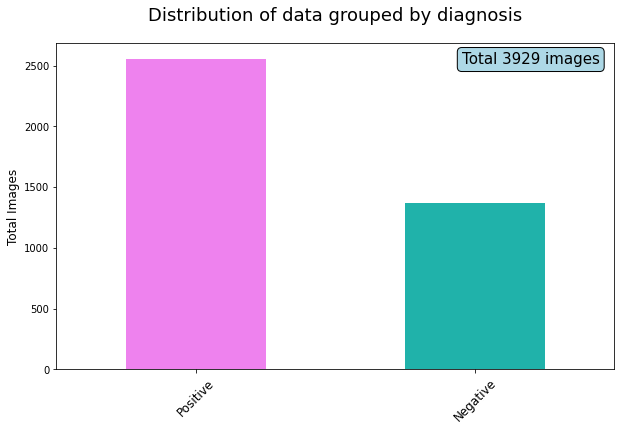

In [37]:
# Plot
ax = dataset.tumor.value_counts().plot(kind='bar',
                                      stacked=True,
                                      figsize=(10, 6),
                                     color=["violet", "lightseagreen"])


ax.set_xticklabels(["Positive", "Negative"], rotation=45, fontsize=12);
ax.set_ylabel('Total Images', fontsize = 12)
ax.set_title("Distribution of data grouped by diagnosis",fontsize = 18, y=1.05)

# Annotate
for i, rows in enumerate(dataset.tumor.value_counts().values):
    ax.annotate(int(rows), xy=(i, rows-12), 
                rotation=0, color="white", 
                ha="center", verticalalignment='bottom', 
                fontsize=15, fontweight="bold")
    
ax.text(1.2, 2550, f"Total {len(dataset)} images", size=15,
        color="black",
         ha="center", va="center",
         bbox=dict(boxstyle="round",
                   fc=("lightblue"),
                   ec=("black"),
                   )
         );

